### Приоритизация гипотез.

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [2]:
df_hip = pd.read_csv('/datasets/hypothesis.csv')
pd.options.display.max_colwidth = 150

In [3]:
df_hip

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
df_hip['ICE'] = ((df_hip['Impact'] * df_hip['Confidence']) / df_hip['Efforts']).round(2)
df_hip['RICE'] = (df_hip['Reach'] * df_hip['Impact'] * df_hip['Confidence']) / df_hip['Efforts']
sort_ICE = df_hip.sort_values('ICE', ascending=False)[['Hypothesis', 'ICE']]
sort_RICE = df_hip.sort_values('RICE', ascending=False)[['Hypothesis', 'RICE']]
df_hip[['Hypothesis', 'ICE', 'RICE']]

,Hypothesis,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2


In [5]:
pattern = re.compile(r'\w+')
a = sort_ICE['Hypothesis'].map(lambda x: pattern.findall(x)[:6]).reset_index()
b = sort_RICE['Hypothesis'].map(lambda x: pattern.findall(x)[:6]).reset_index()
a.columns = ['№', 'Hypothesis_ICE_sort']
b.columns = ['№', 'Hypothesis_RICE_sort']
a = pd.DataFrame(a)
b = pd.DataFrame(b)

In [6]:
df_col = pd.concat([a,b], axis=1)
df_col['Hypothesis_ICE_sort'] = df_col['Hypothesis_ICE_sort'].map(lambda x: ' '.join(map(str, x)))
df_col['Hypothesis_RICE_sort'] = df_col['Hypothesis_RICE_sort'].map(lambda x: ' '.join(map(str, x)))
df_col

,№,Hypothesis_ICE_sort,№,Hypothesis_RICE_sort
0,8,Запустить акцию дающую скидку на товар,7,Добавить форму подписки на все основные
1,0,Добавить два новых канала привлечения трафика,2,Добавить блоки рекомендаций товаров на сайт
2,7,Добавить форму подписки на все основные,0,Добавить два новых канала привлечения трафика
3,6,Показать на главной странице баннеры с,6,Показать на главной странице баннеры с
4,2,Добавить блоки рекомендаций товаров на сайт,8,Запустить акцию дающую скидку на товар
5,1,Запустить собственную службу доставки что сократит,3,Изменить структура категорий что увеличит конверсию
6,5,Добавить страницу отзывов клиентов о магазине,1,Запустить собственную службу доставки что сократит
7,3,Изменить структура категорий что увеличит конверсию,5,Добавить страницу отзывов клиентов о магазине
8,4,Изменить цвет фона главной страницы чтобы,4,Изменить цвет фона главной страницы чтобы


### Анализ A/B-теста

In [7]:
orders = pd.read_csv('/datasets/orders.csv')
orders['date'] = orders['date'].astype('datetime64[D]')
orders.info()
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors.info()
visitors.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
datesGroups = orders[['date','group']].drop_duplicates()

In [10]:
ordersAggregated = datesGroups\
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

In [11]:
visitorsAggregated = datesGroups\
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [12]:
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [13]:
print(cummulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


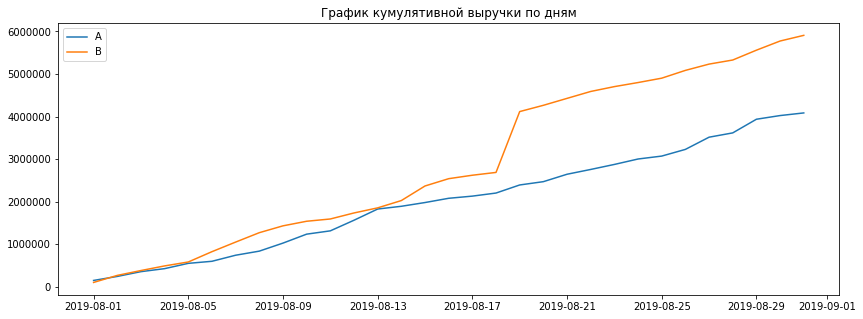

In [14]:
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]
cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(14,5))
plt.title('График кумулятивной выручки по дням')
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')
plt.legend()

В течение всего теста выручка у выборки "B" стабильно выше. 
В данных есть аномалия, которая вызвала рост выручки на графике у группы "В". Если это не всплеск числа заказов, то выброс исказит и данные по среднему чеку.

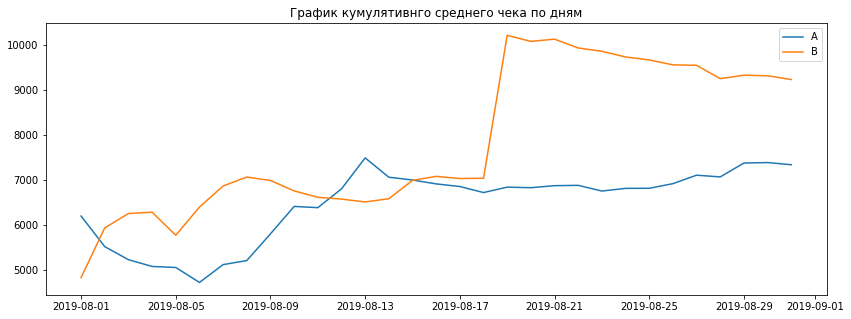

In [15]:
plt.figure(figsize=(14,5))
plt.title('График кумулятивнго среднего чека по дням')
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue']/cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue']/cummulativeRevenueB['orders'], label='B')
plt.legend()

Очевидно, что в данных присутствует очень крупный заказ, который искажает динамику. Нужно избавиться от выбросов

<font color='blue'> Верно. </font>

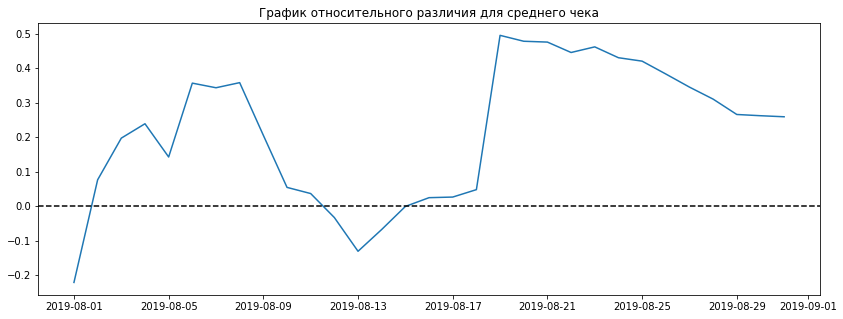

In [16]:
mergedCummulativeRevenue = cummulativeRevenueA.merge(
    cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14,5))
plt.title('График относительного различия для среднего чека')
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])/(
    mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')

С выбросами неинформативно

<font color='blue'> Хорошо. </font>

### Посчитаем кумулятивную конверсию

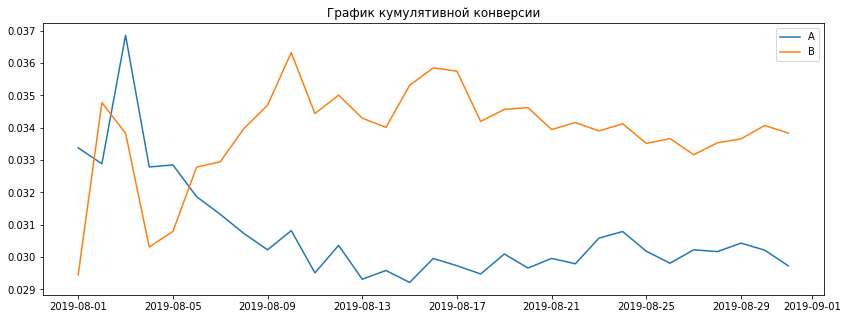

In [17]:
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']

plt.figure(figsize=(14,5))
plt.title('График кумулятивной конверсии')
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
plt.legend()

А вот тут отчетливо видна разница в конверсии в 0.5%. 

### Построим график относительного изменения кумулятивной конверсии группы B к группе A.

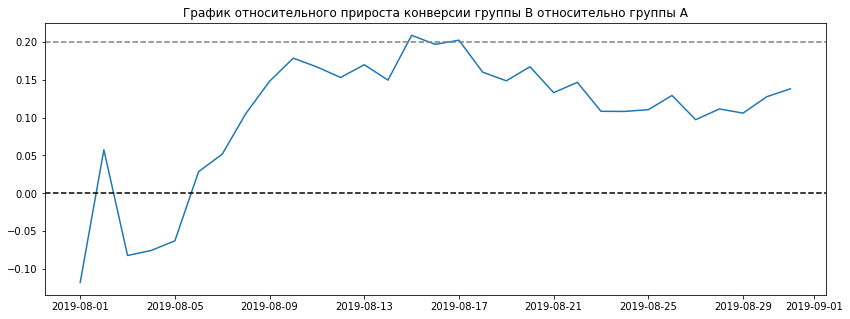

In [18]:
mergedCummulativeConversions = cummulativeDataA[['date','conversion']]\
.merge(cummulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(14,5))
plt.plot(mergedCummulativeConversions['date'], mergedCummulativeConversions['conversionB']\
         /mergedCummulativeConversions['conversionA']-1)
plt.title('График относительного прироста конверсии группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

Очевидно, что показатели конверсии устоялись и группа "В" явный лидер.

### Поиск выбросов

In [19]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg('count')[['visitorId', 'transactionId']]
ordersByUsers.columns = ['userId','orders']
ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


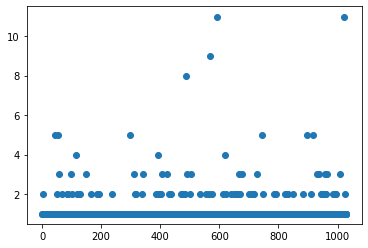

In [20]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

In [21]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

Аномальными пользователямя выберем тех, кто совершил строго больше 5 заказов.

In [22]:
orders['revenue'].describe().round(2)

count       1197.00
mean        8348.01
std        39191.13
min           50.00
25%         1220.00
50%         2978.00
75%         8290.00
max      1294500.00
Name: revenue, dtype: float64

In [23]:
np.percentile(orders['revenue'], [1, 5, 95, 99])

array([  100. ,   300. , 28000. , 58233.2])

За аномалии предлагаю взять 1 и 99 процентили. 

(0, 100)

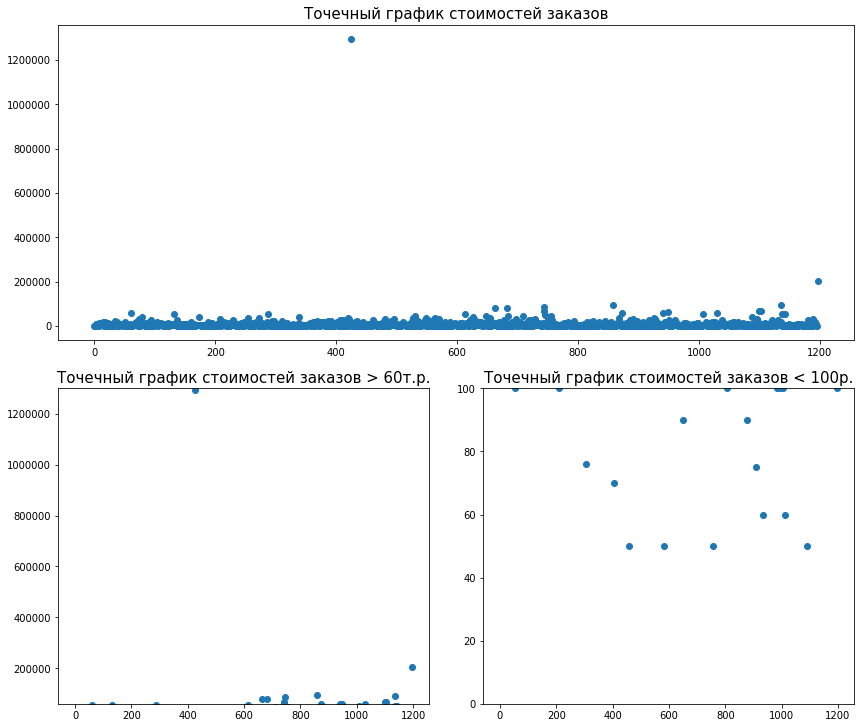

In [24]:
x_values = pd.Series(range(0,len(orders)))
fg = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fg.add_gridspec(2, 2)
fig_ax_1 = fg.add_subplot(gs[0, :])
fig_ax_1.set_title('Точечный график стоимостей заказов', fontsize=15)
plt.scatter(x_values, orders['revenue'])
fig_ax_2 = fg.add_subplot(gs[1, 0])
fig_ax_2.set_title('Точечный график стоимостей заказов > 60т.р.', fontsize=15)
plt.scatter(x_values, orders['revenue'])
plt.ylim(60000, 1300000)
fig_ax_3 = fg.add_subplot(gs[1, 1])
fig_ax_3.set_title('Точечный график стоимостей заказов < 100р.', fontsize=15)
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 100)

Наши предположения подтвердились, аномальными будем считать заказы более 60т.р. и ниже 100р.

#### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [25]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


In [26]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [27]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [28]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.008
0.138


p-value меньше 0.05, значит статистически значимые различия в конверсии между группами есть. Относительный проигрыш группы А равен 13.8%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [30]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


p-value больше 0.05, причин считать, что в среднем чеке есть различия, нет. А вот средний чек группы А значительно ниже среднего чека группы В, почти на 26%. Это все тот миллионный чек.

### Очистим данные.

In [31]:
black_list = ordersByUsers.sort_values(by='orders',ascending=False).head(4)['userId'].values
orders = orders[(orders['revenue'] > 100) & (orders['revenue'] < 60000)] # избавимся от выбросов по сумме чека
orders = orders[~orders['visitorId'].isin(black_list)] # и от заказов больше 5

#### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

In [32]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [33]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [34]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.007
0.158


Результаты в конверсии практически не изменились. Стат. значимость так же присутствует, относительный проигрыш группы А увеличился на 2%. 

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [35]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.423
0.005


p-value все еще достаточно высок, чтобы говорить о стат. значимости в различаях, а вот разница в среднем чеке сравнительно с "сырыми" данными сошла практически полность на нет. с 26% до 0.5%. 